# Cursive English Handwritten Character Classification: Exploratory Data Analysis
# ------------------------------------------------------------------------------

### Notebook Overview:
This notebook will be used to explore and understand the cursive handwriting dataset derived from the CVL database. We will be:
1. Previewing Dataset
2. Check Data Quality and Clean
3. Class Distribution Analysis
4. Visual Explorations
5. Statistical Summaries
6. Preliminary Feature or Embedding Analysis
7. EDA Conclusion

In [2]:
%pip install torchsummary pytest
%pip install pandas matplotlib seaborn pillow torchvision scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torchvision.transforms as transforms
from PIL import Image

import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report
from importlib import reload

# Checking if CUDA is available
flag_cuda = torch.cuda.is_available()

if flag_cuda:
    print("Using GPU")
else:
    print("Using CPU")

Using CPU


## 1. Preview the Data
### In this section, we will:
### 1. Examine the folder structure for our dataset.
### 2. Count how many files are in each subdirectory.
### 3. Visualize a few random images from the `lines`, `pages`, and `words` directories.

Folder Structure and File Counts:
- lines: 13473 files found
- pages: 1604 files found
- words: 99904 files found
- xml: 1604 files found
Displaying random images from 'lines' folder:


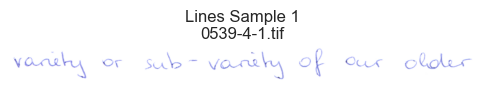

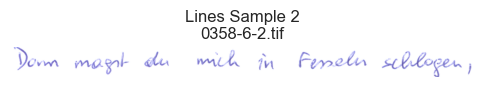

Displaying random images from 'pages' folder:


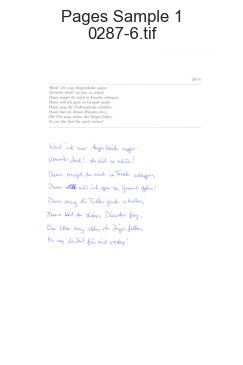

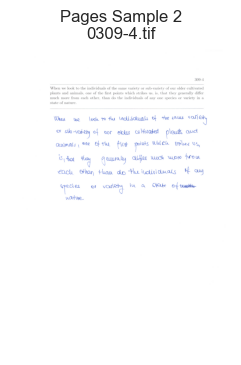

Displaying random images from 'words' folder:


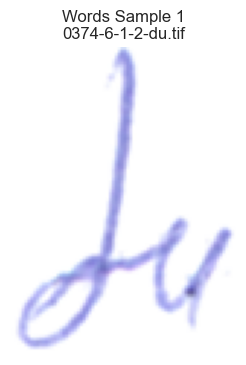

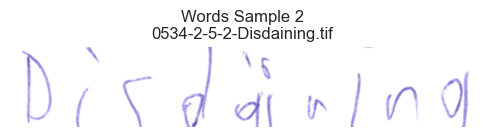

Error processing cvl-database-1-1\full_dataset\lines\0001\0001-6-6.tif: cannot identify image file 'cvl-database-1-1\\full_dataset\\lines\\0001\\0001-6-6.tif'
--- lines Stats (from 100 samples) ---
Most common widths: [(1882, 2), (1294, 2), (1895, 2), (1958, 2), (1820, 2)]
Most common heights: [(114, 5), (102, 4), (127, 4), (138, 4), (105, 3)]
Image modes: Counter({'RGB': 99})

--- pages Stats (from 100 samples) ---
Most common widths: [(2480, 5), (2546, 4), (2538, 3), (2529, 3), (2494, 3)]
Most common heights: [(3553, 5), (3507, 5), (3548, 4), (3539, 3), (3550, 3)]
Image modes: Counter({'RGB': 100})

--- words Stats (from 100 samples) ---
Most common widths: [(146, 3), (144, 3), (124, 2), (206, 2), (120, 2)]
Most common heights: [(59, 5), (72, 4), (65, 4), (78, 4), (58, 3)]
Image modes: Counter({'RGB': 100})



In [16]:
import os
import glob
import random
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

# Base path to the CVL database
BASE_PATH = 'cvl-database-1-1/full_dataset'

# Subfolders in the full_dataset directory
subfolders = ['lines', 'pages', 'words', 'xml']

# 1. Folder Structure and File Counts

print("Folder Structure and File Counts:")
for folder in subfolders:
    folder_path = os.path.join(BASE_PATH, folder)

    # Get all files (recursively), adjusting the pattern as needed for your file types
    all_files = glob.glob(os.path.join(folder_path, '**', '*.*'), recursive=True)
    print(f"- {folder}: {len(all_files)} files found")

# 2. Random Image Preview

def show_random_image(folder_name, num_samples=1):
    """
    Display 'num_samples' random images from the specified folder (including its subfolders).
    """
    folder_path = os.path.join(BASE_PATH, folder_name)

    # Find image files; adjust for your file extension(s): *.tif, *.png, *.jpg, etc.
    image_files = glob.glob(os.path.join(folder_path, '**', '*.tif'), recursive=True)

    if not image_files:
        print(f"No image files found in '{folder_path}'.")
        return

    # Randomly sample from the list of image files
    random_files = random.sample(image_files, k=min(num_samples, len(image_files)))

    for i, file_path in enumerate(random_files, 1):
        img = Image.open(file_path)
        plt.figure(figsize=(6, 4))
        plt.imshow(img, cmap='gray')  # Assuming grayscale images
        plt.title(f"{folder_name.capitalize()} Sample {i}\n{os.path.basename(file_path)}")
        plt.axis('off')
        plt.show()

for folder_name in ['lines', 'pages', 'words']:
    print(f"Displaying random images from '{folder_name}' folder:")
    show_random_image(folder_name, num_samples=2)

# 3. Image Statistics (Dimensions and Modes)

def get_image_stats(folder_name, num_samples=100):
    """
    Gather statistics on image dimensions (width, height) and mode (e.g., L, RGB)
    from a random subset of images in the specified folder.
    """
    # Build and normalize the folder path
    folder_path = os.path.normpath(os.path.join(BASE_PATH, folder_name))

    if not os.path.isdir(folder_path):
        print(f"Folder does not exist: {folder_path}")
        return

    # Find image files with the .tif extension (adjust the extension if necessary)
    image_files = glob.glob(os.path.join(folder_path, '**', '*.tif'), recursive=True)
    # Normalize each file path
    image_files = [os.path.normpath(f) for f in image_files]

    if not image_files:
        print(f"No image files found in '{folder_path}'.")
        return

    # Take a random subset of files to analyze
    random_files = random.sample(image_files, min(num_samples, len(image_files)))

    sizes = []
    modes = []

    for file_path in random_files:
        try:
            with Image.open(file_path) as img:
                sizes.append(img.size)  # (width, height)
                modes.append(img.mode)  # e.g., "L" or "RGB"
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    width_counts = Counter([size[0] for size in sizes])
    height_counts = Counter([size[1] for size in sizes])
    mode_counts = Counter(modes)

    print(f"--- {folder_name} Stats (from {len(random_files)} samples) ---")
    print(f"Most common widths: {width_counts.most_common(5)}")
    print(f"Most common heights: {height_counts.most_common(5)}")
    print(f"Image modes: {mode_counts}")
    print()

# Test the function on folders: lines, pages, and words
for folder_name in ['lines', 'pages', 'words']:
    get_image_stats(folder_name, num_samples=100)

# 2. Data Quality and Cleaning

In [20]:
import os
import glob
import random
import xml.etree.ElementTree as ET

# Base path to the CVL database, normalized for the current OS
BASE_PATH = os.path.normpath('cvl-database-1-1/full_dataset')

# Function to inspect a sample XML file for language labels
def inspect_xml_file(xml_folder='xml', num_samples=1):
    """
    Parse and display a sample XML file to check for language or other label information.
    """
    xml_path = os.path.normpath(os.path.join(BASE_PATH, xml_folder))
    xml_files = glob.glob(os.path.join(xml_path, '**', '*.xml'), recursive=True)
    xml_files = [os.path.normpath(f) for f in xml_files]

    if not xml_files:
        print(f"No XML files found in {xml_path}")
        return

    sample_xml = random.sample(xml_files, min(num_samples, len(xml_files)))
    for xml_file in sample_xml:
        print(f"Parsing XML file: {xml_file}")
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            # Print first-level tags and their attributes
            for child in root:
                print(f"Tag: {child.tag}, Attributes: {child.attrib}")
                # Check if a language tag is present
                if child.tag.lower() == 'language' and child.text:
                    print("Language:", child.text.strip())
            print()
        except Exception as e:
            print(f"Error parsing XML file {xml_file}: {e}")

# Function to filter out German texts based on XML file language info
def filter_german_images(xml_folder='xml'):
    """
    Identify XML files that indicate non-English (e.g., German) text so that their associated images can be excluded.
    """
    xml_path = os.path.normpath(os.path.join(BASE_PATH, xml_folder))
    xml_files = glob.glob(os.path.join(xml_path, '**', '*.xml'), recursive=True)
    xml_files = [os.path.normpath(f) for f in xml_files]

    german_xml_files = []

    for xml_file in xml_files:
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            # Assuming that a tag named 'language' indicates the language of the text
            for element in root.iter():
                if element.tag.lower() == 'language' and element.text:
                    language = element.text.strip().lower()
                    if language != 'english':
                        german_xml_files.append(xml_file)
                        print(f"German text detected in {xml_file} (Language: {language})")
                        break
        except Exception as e:
            print(f"Error processing XML file {xml_file}: {e}")

    print(f"Total German XML files found: {len(german_xml_files)}")
    # Optionally, you could then proceed to remove or flag images associated with these XML files.

# Example usage:
print("### Inspecting a Sample XML File ###")
inspect_xml_file(xml_folder='xml', num_samples=1)

print("### Filtering Out German Texts Based on XML Files ###")
filter_german_images(xml_folder='xml')


### Inspecting a Sample XML File ###
Parsing XML file: cvl-database-1-1\full_dataset\xml\0229-6_attributes.xml
Error parsing XML file cvl-database-1-1\full_dataset\xml\0229-6_attributes.xml: encoding specified in XML declaration is incorrect: line 1, column 30
### Filtering Out German Texts Based on XML Files ###
Error processing XML file cvl-database-1-1\full_dataset\xml\0001-1_attributes.xml: encoding specified in XML declaration is incorrect: line 1, column 30
Error processing XML file cvl-database-1-1\full_dataset\xml\0001-2_attributes.xml: encoding specified in XML declaration is incorrect: line 1, column 30
Error processing XML file cvl-database-1-1\full_dataset\xml\0001-3_attributes.xml: encoding specified in XML declaration is incorrect: line 1, column 30
Error processing XML file cvl-database-1-1\full_dataset\xml\0001-4_attributes.xml: encoding specified in XML declaration is incorrect: line 1, column 30
Error processing XML file cvl-database-1-1\full_dataset\xml\0001-6_attrib